In [72]:
import os
import sys
sys.path.append("/Users/davidenicotra/Projects/Allen QTracking/lhcbqtracking") # !! Change this !!
import q_event_model as em
import toymodel_3d as toy
import regularized_hamiltonian_3d as ham
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

# Generate a simple toy model event

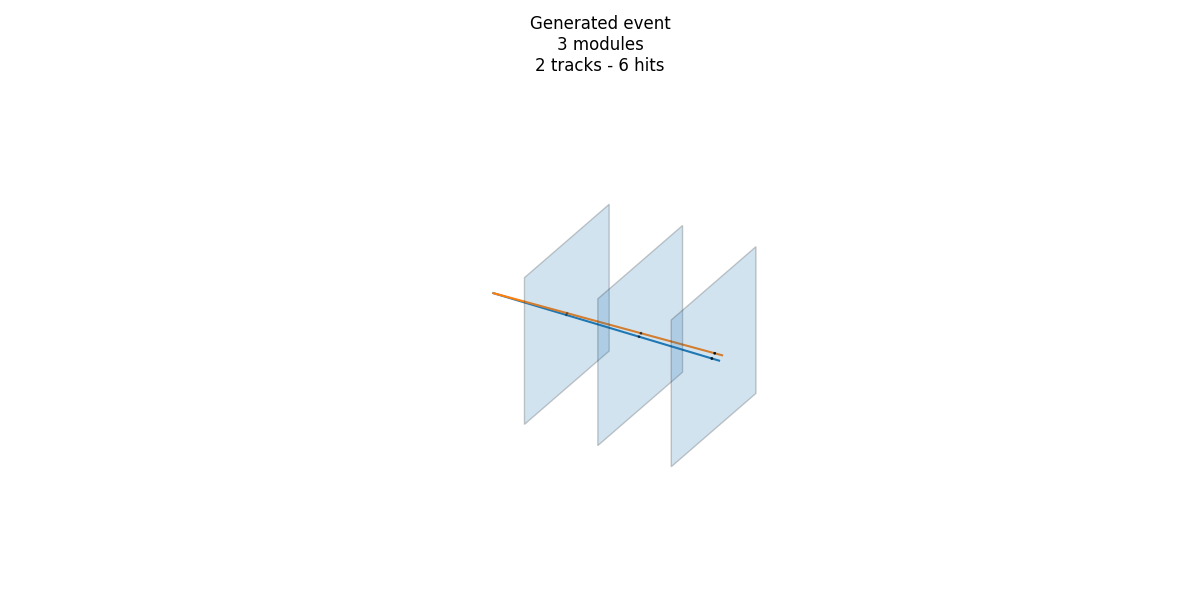

In [73]:
N_MODULES = 3
N_TRACKS = 2

LX = 2
LY = 2
SPACING = 1

detector = toy.generate_simple_detector(N_MODULES, LX, LY, SPACING)
event = toy.generate_event(detector, N_TRACKS,theta_max=np.pi/50, seed = 1)

fig = plt.figure()
fig.set_size_inches(12,6)
ax = plt.axes(projection='3d')
event.display(ax)
ax.view_init(vertical_axis='y')
fig.set_tight_layout(True)
ax.axis('off')
ax.set_title(f"Generated event\n{len(event.modules)} modules\n{len(event.tracks)} tracks - {len(event.hits)} hits")
plt.show()

# Generating the Hamiltonian

Text(0.5, 0.92, '8 segments generated')

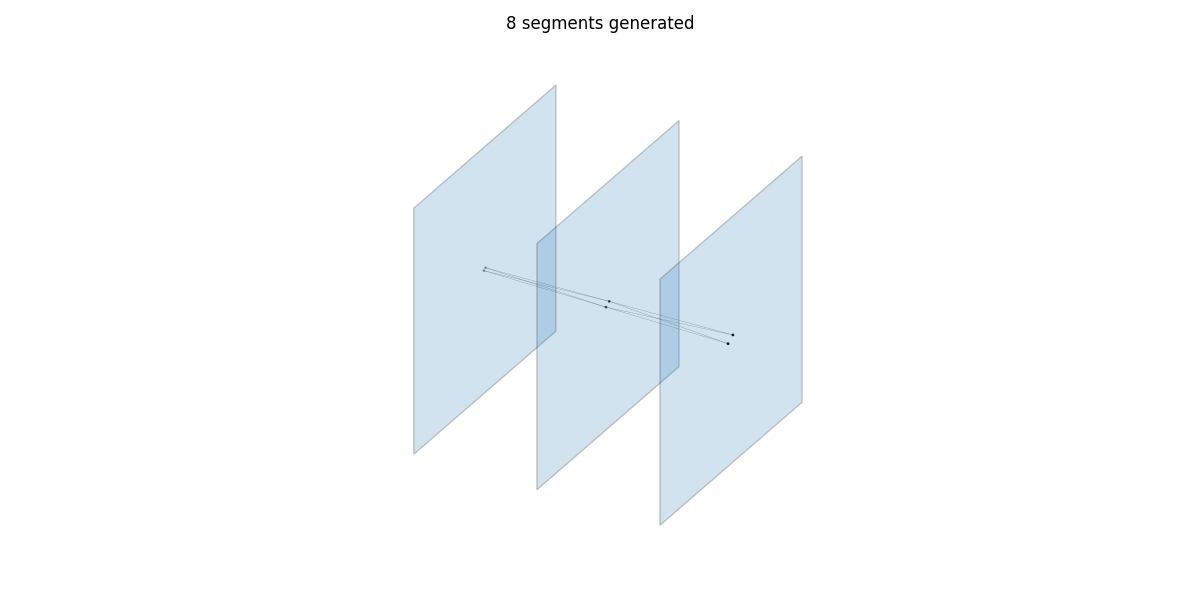

In [74]:
params = {
  'alpha' : 0.0,
  'delta' : 1.0,
  'eps'   : 1e-9,
  'gamma' : 2
}
A, b, components, segments = ham.generate_hamiltonian(event, params)

fig = plt.figure()
fig.set_size_inches(12,6)
ax = plt.axes(projection='3d')
event.display(ax,show_tracks=False)

for segment in segments:
  segment.display(ax)
  
ax.view_init(vertical_axis='y')
fig.set_tight_layout(True)
ax.axis('off')

ax.set_title(f"{len(segments)} segments generated")

# Upscaling to a power of 2

In [75]:
def upscale_pow2(A,b):
    m = A.shape[0]
    d = int(2**np.ceil(np.log2(m)) - m)
    if d > 0:
        A_tilde = np.block([[A, np.zeros((m, d),dtype=np.float64)],[np.zeros((d, m),dtype=np.float64), np.eye(d,dtype=np.float64)]])
        b_tilde = np.block([b,b[:d]])
        return A_tilde, b_tilde
    else:
        return A, b



A, b = upscale_pow2(A,b)

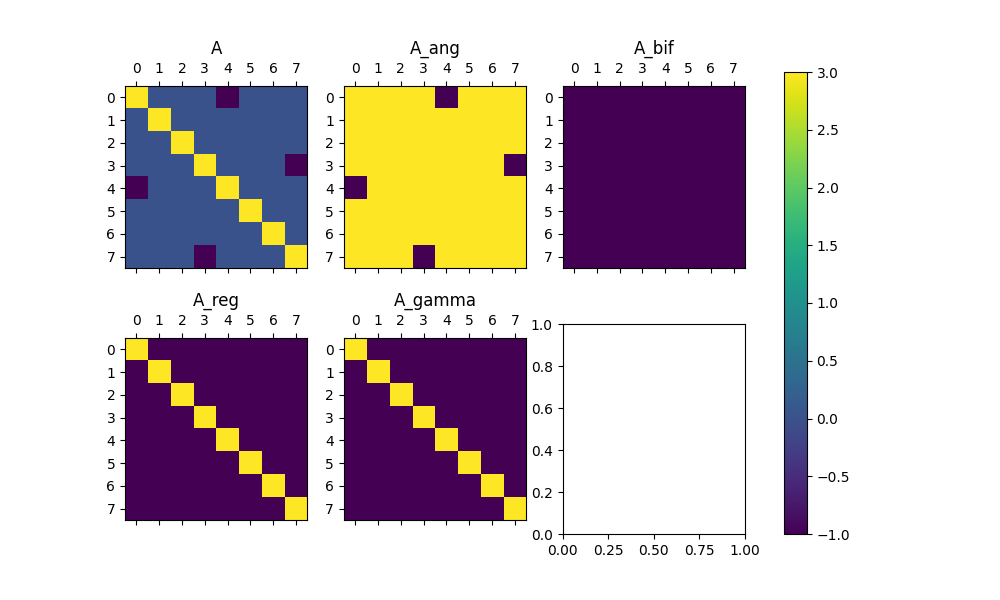

In [76]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(10,6)
vmin = np.min([A.min()].extend(components[key].min() for key in components))
vmax = np.max([A.max()].extend(components[key].max() for key in components))
im = axs[0,0].matshow(A,vmin=vmin, vmax=vmax)
axs[0,0].set_title("A")

axs_raviter = iter(axs.ravel())
next(axs_raviter)
for key in components:
    ax = next(axs_raviter)
    ax.matshow(components[key],vmin=vmin, vmax=vmax)
    ax.set_title(key)

fig.colorbar(im, ax=axs.ravel().tolist())

# Initializing Qiskit's HHL

In [77]:
from qiskit.algorithms.linear_solvers import hhl
import qiskit
from qiskit.quantum_info import Statevector, Operator
import qiskit.circuit


backend = qiskit.Aer.get_backend("aer_simulator_statevector")
solver = hhl.HHL(epsilon=0.1)
b_circuit = qiskit.QuantumCircuit(qiskit.QuantumRegister(int(np.log2(len(b)))), name="init")
for i in range(int(np.log2(len(b)))):
    b_circuit.h(i)




/var/folders/68/q5smjs5j72b08nzdj99csxk40000gn/T/ipykernel_15385/1809797944.py:8: DeprecationWarning: The HHL class is deprecated as of Qiskit Terra 0.22.0 and will be removed
        no sooner than 3 months after the release date.
        It is replaced by the tutorial at https://qiskit.org/textbook/ch-applications/hhl_tutorial.html"
        
  solver = hhl.HHL(epsilon=0.1)


# Constructing the circuit and getting the unitary

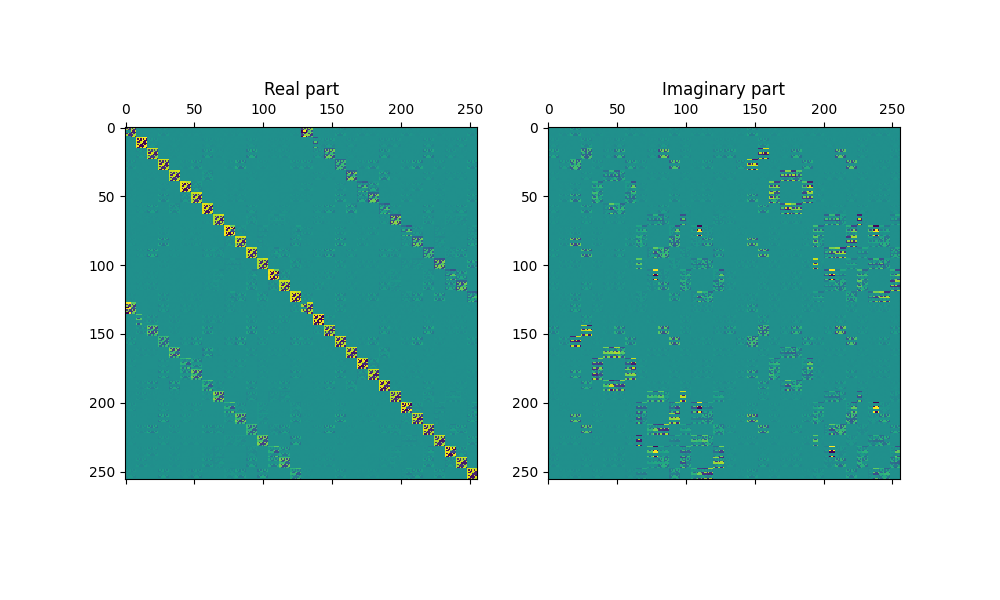

In [78]:
circuit = solver.construct_circuit(A,b_circuit,neg_vals=False)
unitary = Operator(circuit).data
fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,6)
axs[0].matshow(unitary.real)
axs[0].set_title("Real part")
axs[1].matshow(unitary.imag)
axs[1].set_title("Imaginary part")

plt.show()
#circuit.decompose(reps=3).draw(output='mpl',scale=.5)

# Optional: Solving the event

In [79]:
result = solver.solve(A,b_circuit)
sv = Statevector(result.state)

In [80]:
solution_norm = result.euclidean_norm
post_select_qubit = int(np.log2(len(sv.data)))-1
solution_len = len(b)
base = 1 << post_select_qubit
solution_vector = sv.data[base : base+solution_len].real
solution_vector = solution_vector/np.linalg.norm(solution_vector)*solution_norm*np.linalg.norm(b)

In [81]:
solution_segments = [seg for pseudosol, seg in zip(solution_vector,segments) if  pseudosol > 0.45]

Text(0.5, 0.92, 'Solution')

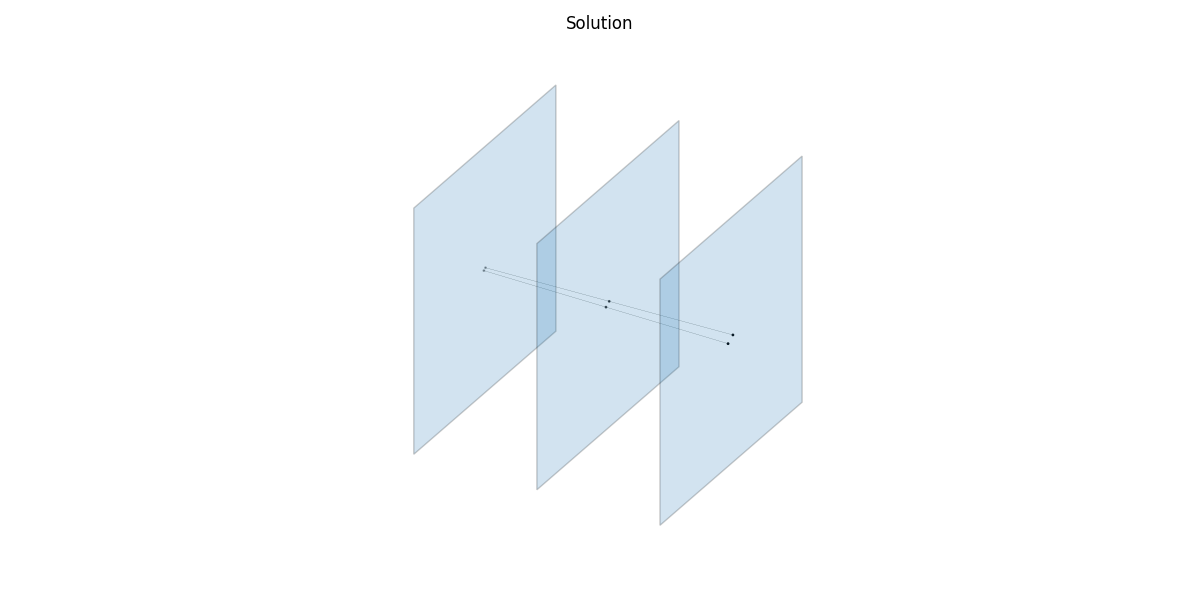

In [82]:
fig = plt.figure()
fig.set_size_inches(12,6)
ax = plt.axes(projection='3d')
event.display(ax,show_tracks=False)

for segment in solution_segments:
  segment.display(ax)
  
ax.view_init(vertical_axis='y')
fig.set_tight_layout(True)
ax.axis('off')

ax.set_title(f"Solution")